# Global and Local Optimization Policies (GLOP)

This notebook is a simple introduction to the Global and Local Optimization Policies (GLOP) from Haoran et al. (2023). Read the paper [here](https://arxiv.org/abs/2312.08224).

## Shortest Hamiltonian Path Problem (SHPP)

This section will introduce the Shortest Hamiltonian Path Problem (SHPP) which is used as solver for partitions in the GLOP algorithm.

In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append(2*'../')

import torch

from rl4co.models.zoo import AttentionModel, AttentionModelPolicy
from rl4co.utils.trainer import RL4COTrainer
from rl4co.envs.routing import SHPPEnv, SHPPGenerator

/home/cbhua/miniconda/envs/rl4co/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
generator = SHPPGenerator(num_loc=20)
env = SHPPEnv(generator) 

embed_dim = 128

policy = AttentionModelPolicy(
    embed_dim=embed_dim,
    env_name=env.name,
)

model = AttentionModel(
    env, 
    policy,
    baseline="rollout",
    train_data_size=100_000,
    val_data_size=10_000,
    optimizer_kwargs={"lr": 1e-4},
) 

/home/cbhua/miniconda/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/cbhua/miniconda/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


Problem 1 | Cost: 6.879
Problem 2 | Cost: 6.445
Problem 3 | Cost: 7.478


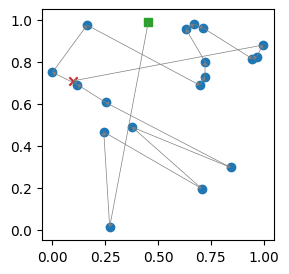

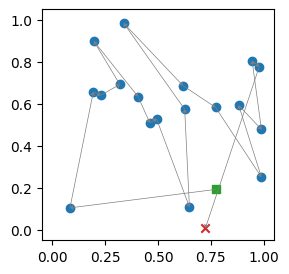

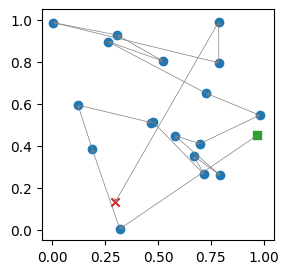

In [3]:
# Greedy rollouts over untrained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

In [4]:
trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    devices=1,
    logger=None,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cbhua/miniconda/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [5]:
trainer.fit(model)

Missing logger folder: /home/cbhua/github/rl4co/examples/other/lightning_logs
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | SHPPEnv              | 0     
1 | policy   | AttentionModelPolicy | 727 K 
2 | baseline | WarmupBaseline       | 727 K 
--------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.819     Total estimated model params size (MB)


/home/cbhua/miniconda/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/cbhua/miniconda/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 2: 100%|██████████| 196/196 [00:05<00:00, 36.68it/s, v_num=0, train/reward=-4.74, train/loss=-.474, val/reward=-4.63]  

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 196/196 [00:06<00:00, 32.46it/s, v_num=0, train/reward=-4.74, train/loss=-.474, val/reward=-4.63]


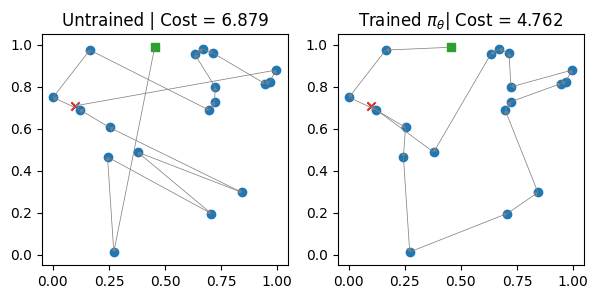

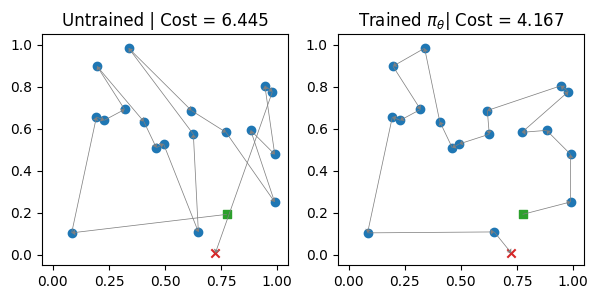

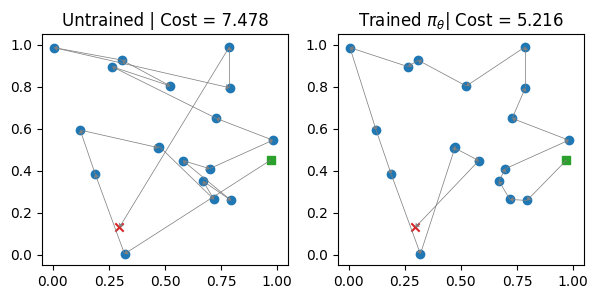

In [6]:
# Greedy rollouts over trained model (same states as previous plot)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(7, 3))
    env.render(td, actions_untrained[i], ax=axs[0]) 
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

## Testing GLOP

This section will test the GLOP algorithm on a simple example.

**NOTE**: The current implementation of the GLOP algorithm is not training with some hidden bugs. We need to fix it.

In [1]:
from rich.traceback import install; install()
%load_ext autoreload
%autoreload 2

import sys; sys.path.append(2*'../')

import torch
import matplotlib.pyplot as plt

from matplotlib import cm

from rl4co.envs import TSPEnv, CVRPEnv, SHPPEnv
from rl4co.models.zoo import (
    AttentionModel,
    AttentionModelPolicy,
    GLOP,
    GLOPPolicy,
)
from rl4co.utils.trainer import RL4COTrainer
from rl4co.utils.ops import batchify, gather_by_index

/home/cbhua/miniconda/envs/rl4co/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Train SHPP revisers from scratch

Follow the previous SHPP training pipeline.

In [ ]:
# reviser_size_list = [10, 20, 50]

# reviser_list = []
# for reviser_idx, reviser_size in enumerate(reviser_size_list):
#     env = SHPPEnv(generator_params={"num_loc": reviser_size}) 

#     embed_dim = 128

#     policy = AttentionModelPolicy(
#         embed_dim=embed_dim,
#         env_name=env.name,
#     )

#     reviser = AttentionModel(
#         env, 
#         policy,
#         baseline="rollout",
#         train_data_size=100_000,
#         val_data_size=10_000,
#         optimizer_kwargs={"lr": 1e-4},
#     )

#     trainer = RL4COTrainer(
#         max_epochs=3,
#         accelerator="gpu",
#         devices=1,
#         logger=None,
#     )

#     trainer.fit(reviser)
#     reviser_list.append(reviser)

### Load SHPP revisers from checkpoints

Load pretrained SHPP revisers.

In [2]:
reviser_root_path = "../../checkpoints/" # NOTE: change to your path
reviser_size_list = [10, 20, 30, 40, 50]

reviser_list = []
for reviser_idx, reviser_size in enumerate(reviser_size_list):
    env = SHPPEnv(generator_params={"num_loc": reviser_size}) 

    embed_dim = 128

    policy = AttentionModelPolicy(
        embed_dim=embed_dim,
        env_name=env.name,
    )

    reviser = AttentionModel(
        env,
        policy,
        baseline="rollout",
        train_data_size=100_000,
        val_data_size=10_000,
        optimizer_kwargs={"lr": 1e-4},
    ) 
    reviser.load_from_checkpoint(reviser_root_path + f"{reviser_size}.ckpt")

    reviser_list.append(reviser)

/home/cbhua/miniconda/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/cbhua/miniconda/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.
/home/cbhua/miniconda/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['baseline.baseline.policy.encoder.init_embedding.init_embed.weight', 'baseline.baseline.policy.encoder.init_embedding.init_embed.bias', 'baseline.baseline.policy.encoder.init_embedding.init_embed_start.weight', 'baseline.baseline.policy.encoder.init_embedding.init

### Test GLOP inference logic and visualize middle results

Before training the GLOP, this section could be useful to understand how the GLOP algorithm works and use it to debug.

In [3]:
# Parameters
num_loc = 100
n_samples = 10

# Create the environment
cvrp_env = CVRPEnv(generator_params={"num_loc": num_loc}) 

# Init policy
policy = GLOPPolicy(
    env_name=cvrp_env.name,
    n_samples=n_samples,
    revisers=reviser_list,
)

# Test policy with greedy rollout with untrained model
device = "cuda:1"
policy = policy.to(device)

td = cvrp_env.reset(batch_size=[3]).to(device)
out = policy(
    td=td.clone(),
    env=cvrp_env,
    phase="test",
    return_actions=True,
    return_partitions=True,
    return_partitions_actions=True,
)

In [4]:
# Print the information of outputs
print(f"out keys: {out.keys()}")

reward = out['reward']
final_actions = out['actions']
heatmap_actions = out['par_actions']
reviser_actions = out['revised_actions']
partition = out['partition']

print(f'Final   Actions Size [B*S, FL]  :\t{final_actions.size()}')
print(f'Heatmap Actions Size [B*S, HL]  :\t{heatmap_actions.size()}')
print(f'Reviser Actions Size [B*S*P, PL]:\t{reviser_actions.size()}')
print(f'Partition       Size [B*S, P, L]:\t{partition.size()}')

out keys: dict_keys(['log_likelihood', 'reward', 'actions', 'partition', 'par_actions', 'revised_actions'])
Final   Actions Size [B*S, FL]  :	torch.Size([30, 288])
Heatmap Actions Size [B*S, HL]  :	torch.Size([30, 115])
Reviser Actions Size [B*S*P, PL]:	torch.Size([480, 18])
Partition       Size [B*S, P, L]:	torch.Size([30, 16, 18])


In [5]:
# Choose the sample to visualize
batch_size = 3
batch_idx = 0
sample_idx = 0
case_idx = batch_idx * n_samples + sample_idx
n_partitions = out["partition"].size(1)

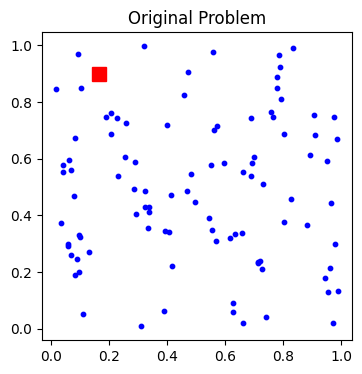

In [6]:
# Visualize the original problem
original_locs = td["locs"][batch_idx].cpu().detach()

# Plotting
fig, ax = plt.subplots(figsize=(4, 4))

# Plot the cities
ax.scatter(original_locs[1:, 0], original_locs[1:, 1], c='b', s=10)

# Plot the depot
ax.plot(original_locs[0, 0], original_locs[0, 1], 'rs', markersize=10)

# Adding info
ax.set_title("Original Problem")
plt.show()

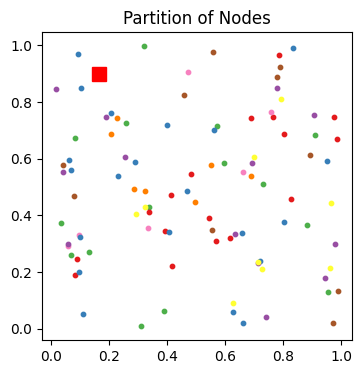

In [7]:
# Visualize the partition
nodes = out["partition"][case_idx].cpu().detach() # [n_partitions, n_nodes]
original_locs = td["locs"][batch_idx].cpu().detach() # [n_nodes, 2]
original_locs_expand = torch.repeat_interleave(original_locs.unsqueeze(0), nodes.size(0), dim=0) # [n_partitions, n_nodes, 2]
partition_locs = gather_by_index(original_locs_expand, nodes) # [n_partitions, n_nodes, 2]

# Plotting
fig, ax = plt.subplots(figsize=(4, 4))

# Plot the cities
for partition_idx in range(partition_locs.shape[0]):
    color = cm.Set1(partition_idx%8)
    ax.scatter(partition_locs[partition_idx, :, 0], partition_locs[partition_idx, :, 1], color=color, s=10)

# Plot the depot
ax.plot(original_locs[0, 0], original_locs[0, 1], 'rs', markersize=10)

# Adding info
ax.set_title("Partition of Nodes")
plt.show()

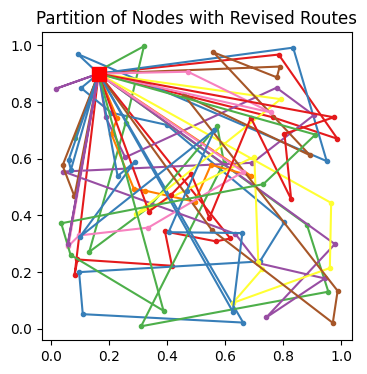

In [8]:
# Visualize the reviser result for partitions
reviser_actions = out["revised_actions"].cpu().detach() # [B*S*P, L]
reviser_actions_reshape = reviser_actions.view(batch_size*n_samples, n_partitions, -1) # [B*S, P, L]: should be the same size as out["partition"]
partition_actions = out["partition"].cpu().detach() # [B*S, P, L]

partition_actions_revised = torch.gather(partition_actions, -1, reviser_actions_reshape) # [B*S, P, L]
partition_actions_revised_sample = partition_actions_revised[case_idx] # [P, L]

# Adding the depot at the first place of each sequence
partition_actions_revised_sample = torch.cat([torch.zeros(partition_actions_revised_sample.size(0), 1).int(), partition_actions_revised_sample], dim=1)

original_locs = td["locs"][sample_idx].cpu().detach() # [n_nodes, 2]
original_locs_expand = torch.repeat_interleave(original_locs.unsqueeze(0), partition_actions_revised_sample.size(0), dim=0) # [P, n_nodes, 2]
locs_partition_revised = gather_by_index(original_locs_expand, partition_actions_revised_sample) # [P, L, 2]

fig, ax = plt.subplots(figsize=(4, 4))

# Plot the cities
for partition_idx in range(n_partitions):
    color = cm.Set1(partition_idx%8)
    ax.plot(locs_partition_revised[partition_idx, :, 0], locs_partition_revised[partition_idx, :, 1], color=color, marker='o', markersize=3)

# Plot the depot
ax.plot(original_locs[0, 0], original_locs[0, 1], 'rs', markersize=10)

# Adding info
ax.set_title("Partition of Nodes with Revised Routes")
plt.show()

### Train the GLOP

**NOTE** The current implementation of the GLOP algorithm is not training with some hidden bugs. We need to fix it. By running the following cell, you will find that the reward is not increasing.

In [9]:
num_loc = 100
n_samples = 10

# Create the environment
cvrp_env = CVRPEnv(generator_params={"num_loc": num_loc}) 

# Init the GLOP model with loaded revisers
model = GLOP(
    env=cvrp_env, 
    revisers=reviser_list,
    n_samples=n_samples,
    baseline="shared",
    batch_size=32,
    train_data_size=10_000,
    val_data_size=1_000,
    optimizer_kwargs={"lr": 1e-4},
) 

trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    devices=[1],
    logger=None,
)

trainer.fit(model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cbhua/miniconda/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type           | Params
--------------------------------------------
0 | env      | CVRPEnv        | 0     

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/cbhua/miniconda/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


/home/cbhua/miniconda/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0:   8%|▊         | 26/313 [00:28<05:18,  0.90it/s, v_num=10, train/reward=-39.2, train/loss=-1.86] 

/home/cbhua/miniconda/envs/rl4co/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
